## Credit:  
[Paper link](https://www.aclweb.org/anthology/P12-2018)  
There's an explanation about nbsvm here: [Kaggle notebook by Jeremy Howard](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline)  
Some detail about its L1 norm: [Detail explanation by Zhangyang](https://www.kaggle.com/zhangyang/explain-l1-norm-nb-svm-strong-linear-baseline)

In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Dataset preview

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
print("%d question texts in train.\n%d question texts in test"
      %(len(train_df), len(test_df)))

1306122 question texts in train.
56370 question texts in test


In [5]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
tr_lens = train_df.question_text.str.len()
print("Train question text length \nmean:\t{}\nstd:\t{}\nmax:\t{}\n"
      .format(tr_lens.mean(), tr_lens.std(), tr_lens.max()))

te_lens = test_df.question_text.str.len()
print("Test question text length \nmean:\t{}\nstd:\t{}\nmax:\t{}"
      .format(te_lens.mean(), te_lens.std(), te_lens.max()))

Train question text length 
mean:	70.67883551459971
std:	38.784276716656976
max:	1017

Test question text length 
mean:	70.46024481106971
std:	38.73142731206794
max:	588


In [7]:
tr_lens.hist()

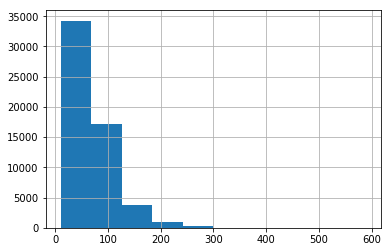

In [8]:
te_lens.hist()

In [9]:
train_df.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


### Null check

In [10]:
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [11]:
test_df.isnull().sum()

qid              0
question_text    0
dtype: int64

### Data distribution check

In [12]:
print("Dataset has %d insincere questions out of %d." %(train_df[train_df['target'] == 1].shape[0],train_df.shape[0]))
print("Takes up %f" %(train_df[train_df['target'] == 1].shape[0]/train_df.shape[0]))


Dataset has 80810 insincere questions out of 1306122.
Takes up 0.061870


### *down sampling

In [13]:
pos = train_df[train_df['target'] == 1]
neg = train_df[train_df['target'] == 0]

In [14]:
samp_neg = neg.sample(100000)

In [15]:
temp = pd.concat([pos,samp_neg], axis=0)

In [16]:
temp.shape

(180810, 3)

In [17]:
temp.head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


shuffle dataframe

In [18]:
temp = temp.sample(frac=1).reset_index(drop=True)

### Train valid split

In [19]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

Split train : valid = 0.8 : 0.2

In [20]:
X_train, X_val, y_train, y_val = train_test_split(train_df['question_text'].tolist(), 
                                                  train_df['target'].tolist(), test_size=0.2)

In [21]:
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
train_df.columns = ['question_text', 'target']
valid_df = pd.concat([pd.DataFrame(X_val), pd.DataFrame(y_val)], axis=1)
valid_df.columns = ['question_text', 'target']

In [22]:
print("{} train samples and {} valid samples".format(len(X_train), len(X_val)))

1044897 train samples and 261225 valid samples


## TF-IDF feature matrix

In [23]:
import re, string

In [24]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(' ', s).split()

In [25]:
n = train_df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, 
                     min_df=3, max_df=0.9, strip_accents='unicode',
                     use_idf=1, smooth_idf=1, sublinear_tf=1)

In [26]:
tr_term = vec.fit_transform(X_train)
va_term = vec.transform(X_val)
te_term = vec.transform(test_df['question_text'])

In [27]:
x = tr_term
y = train_df['target']

val_x = va_term
val_y = valid_df['target']

test_x = te_term

### matrix inspection

In [28]:
x.shape

(1044897, 506867)

There are 1044897 sentences in trainset matrix, with 507086 features (unigram and bigram word of bags)

Randomly select a sentence out of train set:

In [29]:
X_train[5]

'How does Wikipedia store multi-lingual articles in its database?'

It corresponds to the 5-th row in the sparse tfidf matrix, which stored 6 elements:

In [30]:
x[5]

<1x506867 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

Choose word "fantasy" to inspect its index in the vocabulary.

In [31]:
vec.vocabulary_['fantasy']

162001

We can see what's the tfidf value of the word in sentence 5:

In [32]:
x[5,162237]

0.0

To begin with, we want to know the probability of classification of a given sentence: $ P(Class|Sentence) $, since we only have two classes 0,1. We can determine the class by dividing them:  

$$result=\frac{P(C=1|S)}{P(C=0|S)}$$  
  
If it's bigger than 1, the sentence should be classify as 1 (insincere), otherwise 0.   
Or just simply compare which one's bigger.
  
Problem here is how to get the $P(C|S)$:  
According to Naive Bayes,   

$$P(C=1|S)=\frac{P(S|C=1)P(C=1)}{P(S)},P(C=0|S)=\frac{P(S|C=0)P(C=0)}{P(S)}$$
  
thus,  
$$result=\frac{P(S|C=1)}{P(S|C=0)}\frac{P(C=1)}{P(C=0)}$$  
  
$\frac{P(C=1)}{P(C=0)}$ here is a constant, which is the fraction of counts of labeled 1 and 0 question texts.    
  
For P(S|C=1), we consider in Naive Bayes way that every word appears independently. With this assumption, we can say   

$$P(S|C=1) = P(w_1|C)P(w_2|C)P(w_3|C)...P(w_n|C)$$  
$w_i$ is the $i$-th word in sentence $S$    
  
Thus, all we need here is $P(w|C=1)$ and $P(w|C=0)$ for all words in the bag. For every $P(S|C)$, we can just multiply words probabilities together.  
  
Therefore,
$$result=\frac{\prod_{i=0}^nP(w_i|C=1)}{\prod_{i=0}^nP(w_i|C=0)}\frac{P(C=1)}{P(C=0)}$$   
  
Define log ratio by taking log from result:  
$$r =\log\frac{ratio\ of\ word\ w\ in\ class\ 1}{ratio\ of\ word\ w\ in\ class\ 0}= \log\frac{\frac{\boldsymbol{p}}{||\boldsymbol{p}||}}{\frac{\boldsymbol{q}}{||\boldsymbol{q}||}} $$  
  
$\boldsymbol{p}$ here is obtained by adding up every feature(words) in each row(sentence) who belongs to class 1, that gives us $\sum_{i=0}^nlog{P(w_i|C=1)}$. $||\boldsymbol{p}||$ is the normalization term which is $\sum_{i=0}^n P(C=1)$. Considering the smoothing term to prevent the situation that some words never appear in a particular class, $\boldsymbol{p}=\alpha + \sum_{i=0}^nlog{P(w_i|C=1)}$.

In python where x is the feature matrix and y is the target, $\boldsymbol{p}$ equals `alpha + x[y==1].sum(0)` and $||\boldsymbol{p}||$ is `alpha + (y==1).sum()`.













sum(0) sums up every row.  
For every element in a row, it's summing up all the word features(Which is the P(f|class)) in this sentence.

In [33]:
def pr(y_i, y, alpha=1):
    p = x[y==y_i].sum(0)+alpha
    p_norm = (y==y_i).sum()+alpha
    return p/p_norm

In [34]:
def nblr(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True, max_iter=500)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [38]:
def nbsvm(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m =  SVC(C=4, gamma='auto')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
svm, r = nbsvm(train_df['target'])

In [ ]:
lr, r = nblr(train_df['target'])

### validation

In [144]:
preds = np.zeros((len(X_val), 1))
preds = m.predict_proba(val_x.multiply(r))

In [145]:
preds

array([[9.94520312e-01, 5.47968803e-03],
       [9.80391200e-01, 1.96088000e-02],
       [9.96715488e-01, 3.28451171e-03],
       ...,
       [9.91398284e-01, 8.60171566e-03],
       [9.95247821e-01, 4.75217894e-03],
       [9.99202833e-01, 7.97166542e-04]])

In [141]:
preds = np.zeros((len(test_df), 1))
preds = lr.predict_proba(test_x.multiply(r))

In [35]:
subm = pd.read_csv('data/sample_submission.csv')

In [146]:
res = []
for i in range(len(preds)):
    if preds[i][0] > preds[i][1]:
        res.append(0)
    else: res.append(1)

### Local result

In [154]:
from sklearn.metrics import f1_score

f1_score(y_val, res, average='macro') 

0.773617494093656

In [37]:
subm.head()

,qid,prediction
0,00014894849d00ba98a9,0
1,000156468431f09b3cae,0
2,000227734433360e1aae,0
3,0005e06fbe3045bd2a92,0
4,00068a0f7f41f50fc399,0


In [38]:
submission = pd.concat([pd.DataFrame({'qid': subm["qid"]}), 
                        pd.DataFrame(res,columns=["prediction"])],  axis=1)